In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from GeoConformalizedExplainer import GeoConformalizedExplainer

C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('../data/us_election.csv')

In [3]:
data.head()

STATEFP  COUNTYFP  GEOID       ALAND    AWATER       area_name state_abbr  \
0        1         5   1005  2291820706  50864677  Barbour County         AL   
1        1        23   1023  2365954971  19059247  Choctaw County         AL   
2        1        35   1035  2201896058   6643480  Conecuh County         AL   
3        1        51   1051  1601876535  99850740   Elmore County         AL   
4        1        65   1065  1667804583  32525874     Hale County         AL   

   PST045214  PST040210  PST120214  ...  Demvotes12  GOPvotes12  county_fip  \
0      26887      27457       -2.1  ...        5873        5539           5   
1      13323      13858       -3.9  ...        3785        4150          23   
2      12670      13228       -4.2  ...        3551        3434          35   
3      80977      79296        2.1  ...        8940       26223          51   
4      15184      15760       -3.7  ...        5401        3205          65   

   state_fips  pct_dem_12  pct_gop_12  diff_2012  pct_pt_12        lon  \
0           1    0.512523    0.483376        334   0.029147 -85.393211   
1           1    0.475204    0.521030        365  -0.045825 -88.263180   
2           1    0.506345    0.489662        117   0.016683 -86.993674   
3           1    0.252257    0.739927      17283  -0.487669 -86.149159   
4           1    0.625985    0.371465       2196   0.254520 -87.629146   

         lat  
0  31.869580  
1  32.019772  
2  31.429234  
3  32.596647  
4  32.762664  

[5 rows x 76 columns]

In [4]:
dem_pct = data['pct_dem_16']

In [5]:
features = data[['PST045214', 'AGE135214', 'AGE295214', 'AGE775214', 'SEX255214', 'RHI125214',
                 'RHI225214', 'RHI425214', 'RHI525214', 'RHI725214', 'POP645213',
                 'POP815213', 'EDU635213', 'EDU685213', 'VET605213', 'LFE305213', 'INC110213',
                 'PVY020213', 'SBO001207', 'RTN131207', 'lon', 'lat']]

In [6]:
loc = data[['lon', 'lat']]

In [7]:
X_train, X_temp, y_train, y_temp, loc_train, loc_temp = train_test_split(features, dem_pct, loc, train_size=0.8, random_state=42)

In [8]:
X_calib, X_test, y_calib, y_test, loc_calib, loc_test = train_test_split(X_temp, y_temp, loc_temp, train_size=0.5, random_state=42)

In [9]:
model = xgb.XGBRegressor(n_estimators=400, max_depth=3, min_child_weight=0.8, colsample_bytree=0.8)

In [10]:
model.fit(X_train.values, y_train.values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=0.8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
model.score(X_test, y_test)

0.8847633313049152

In [12]:
feature_names = X_train.columns

In [13]:
explainer = GeoConformalizedExplainer(prediction_f=model.predict,
                                      shap_value_f=None,
                                      x_train=X_train,
                                      x_calib=X_calib,
                                      coord_calib=loc_calib.values,
                                      miscoverage_level=0.1,
                                      band_width=3,
                                      feature_names=feature_names)

In [14]:
results = explainer.uncertainty_aware_explain(x_test=X_test, coord_test=loc_test)

Training SHAP


100%|██████████| 2486/2486 [56:32<00:00,  1.36s/it] 


Calibrating SHAP


100%|██████████| 311/311 [05:15<00:00,  1.02s/it]


Testing SHAP


100%|██████████| 311/311 [05:13<00:00,  1.01s/it]


Explaining Variables


C:\Users\Xiayin\PycharmProjects\UncertaintyGeoXAI\GeoConformalizedExplainer\GeoConformalizedExplainer.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature_name}_geo_uncertainty'] = geocp_result.geo_uncertainty
C:\Users\Xiayin\PycharmProjects\UncertaintyGeoXAI\GeoConformalizedExplainer\GeoConformalizedExplainer.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature_name}_uncertainty'] = geocp_result.uncertainty
C:\Users\Xiayin\PycharmProjects\UncertaintyGeoXAI\GeoConformalizedExplainer\GeoConformalizedEx

In [15]:
results.accuracy_summary()

coverage_probability        R2      RMSE  SHAP_Var  Pred_SHAP_Var
PST045214              0.893891  0.769106  0.008603  0.000321       0.000206
AGE135214              0.864952  0.379816  0.002542  0.000010       0.000005
AGE295214              0.938907  0.877194  0.008067  0.000530       0.000492
AGE775214              0.839228  0.181719  0.004872  0.000029       0.000010
SEX255214              0.932476  0.792056  0.004685  0.000106       0.000072
RHI125214              0.868167  0.977542  0.011287  0.005673       0.005163
RHI225214              0.909968  0.949473  0.007406  0.001085       0.001034
RHI425214              0.874598  0.419832  0.006692  0.000077       0.000039
RHI525214              0.903537  0.046121  0.001716  0.000003       0.000005
RHI725214              0.980707  0.978826  0.005629  0.001497       0.001673
POP645213              0.816720  0.622087  0.006535  0.000113       0.000059
POP815213              0.884244  0.823397  0.005195  0.000153       0.000111
EDU635213              0.868167  0.763795  0.003853  0.000063       0.000038
EDU685213              0.935691  0.957935  0.007703  0.001410       0.001303
VET605213              0.871383  0.324215  0.007486  0.000083       0.000020
LFE305213              0.922830  0.353969  0.004624  0.000033       0.000014
INC110213              0.909968  0.589241  0.004725  0.000054       0.000028
PVY020213              0.864952  0.531272  0.003983  0.000034       0.000022
SBO001207              0.929260  0.610486  0.004758  0.000058       0.000033
RTN131207              0.864952  0.216610  0.005810  0.000043       0.000012
lon                    0.938907  0.888835  0.011733  0.001238       0.001093
lat                    0.745981  0.917304  0.014638  0.002591       0.002514

In [16]:
results.accuracy_summary().to_csv('./USElection_accuracy_summary.csv')

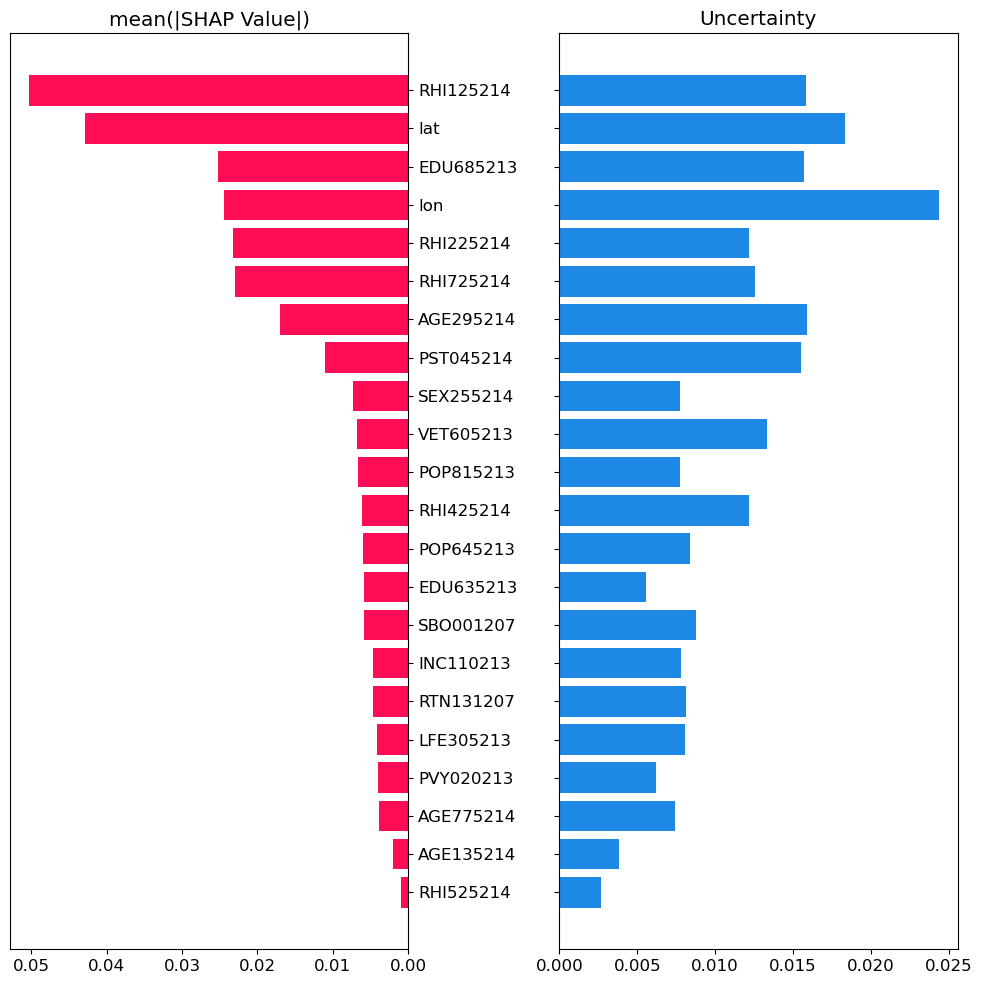

In [17]:
results.plot_absolute_shap_value_with_uncertainty(filename='./USElection_absolute_shap_value_with_uncertainty.pdf')

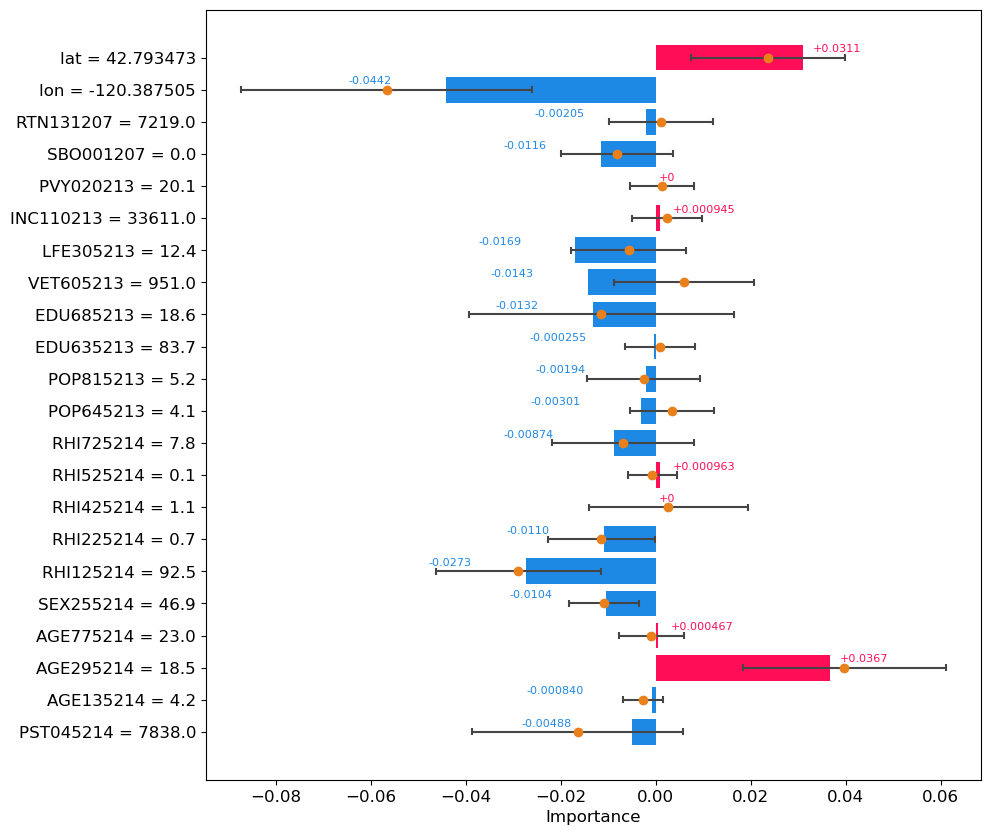

In [18]:
 results.plot_shap_values_with_uncertainty(10, filename='./USElection_shap_values_with_uncertainty.pdf')

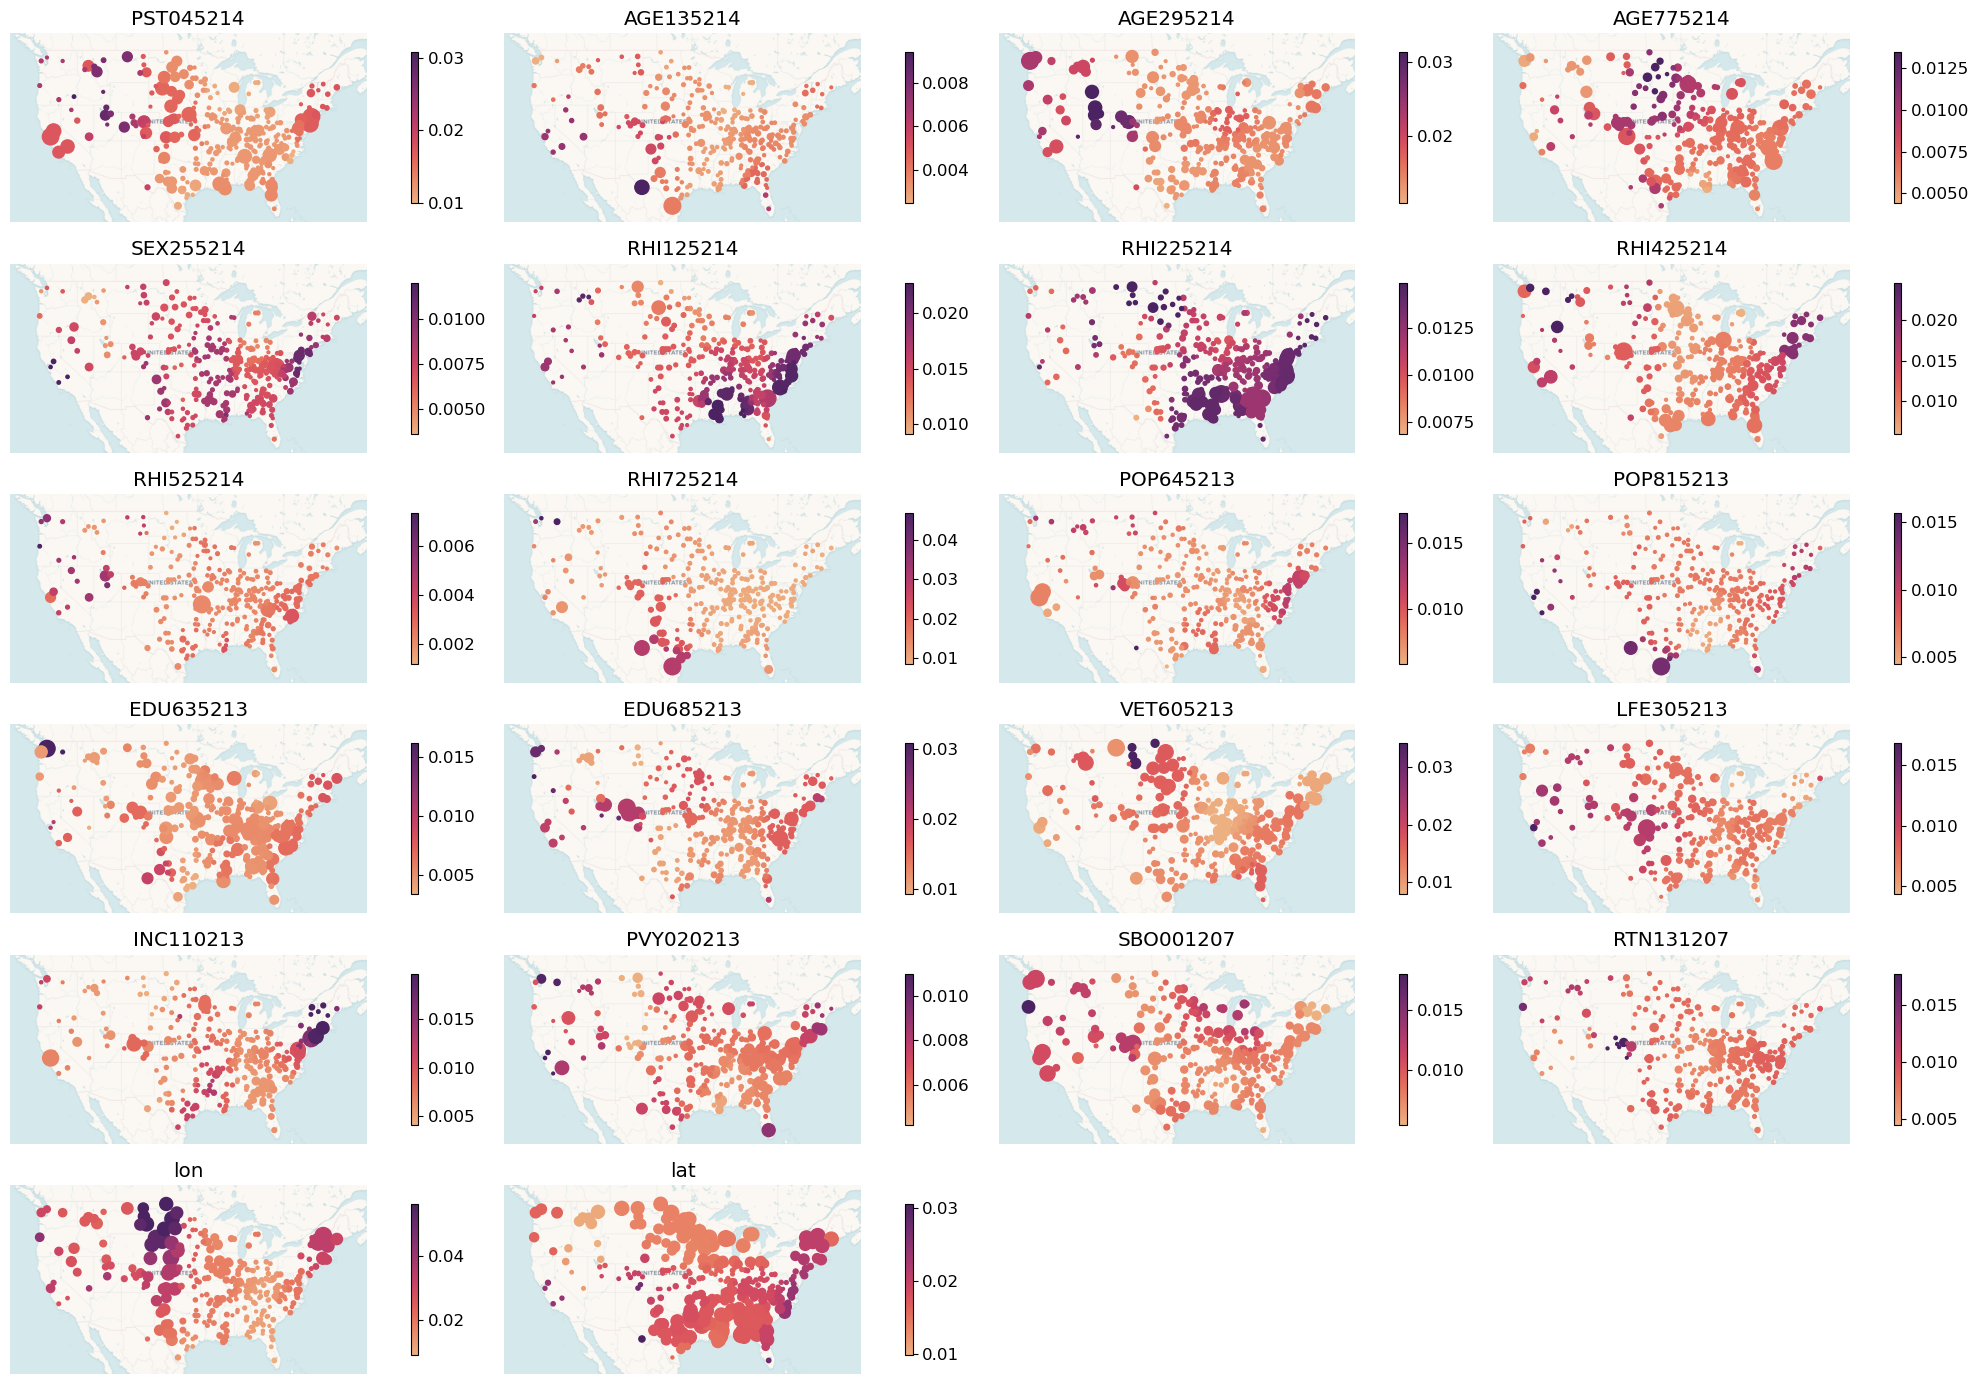

In [29]:
results.plot_geo_uncertainty(max_cols=4, figsize=(24, 14), shrink=0.8, filename='USElection_geo_uncertainty.pdf')

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00

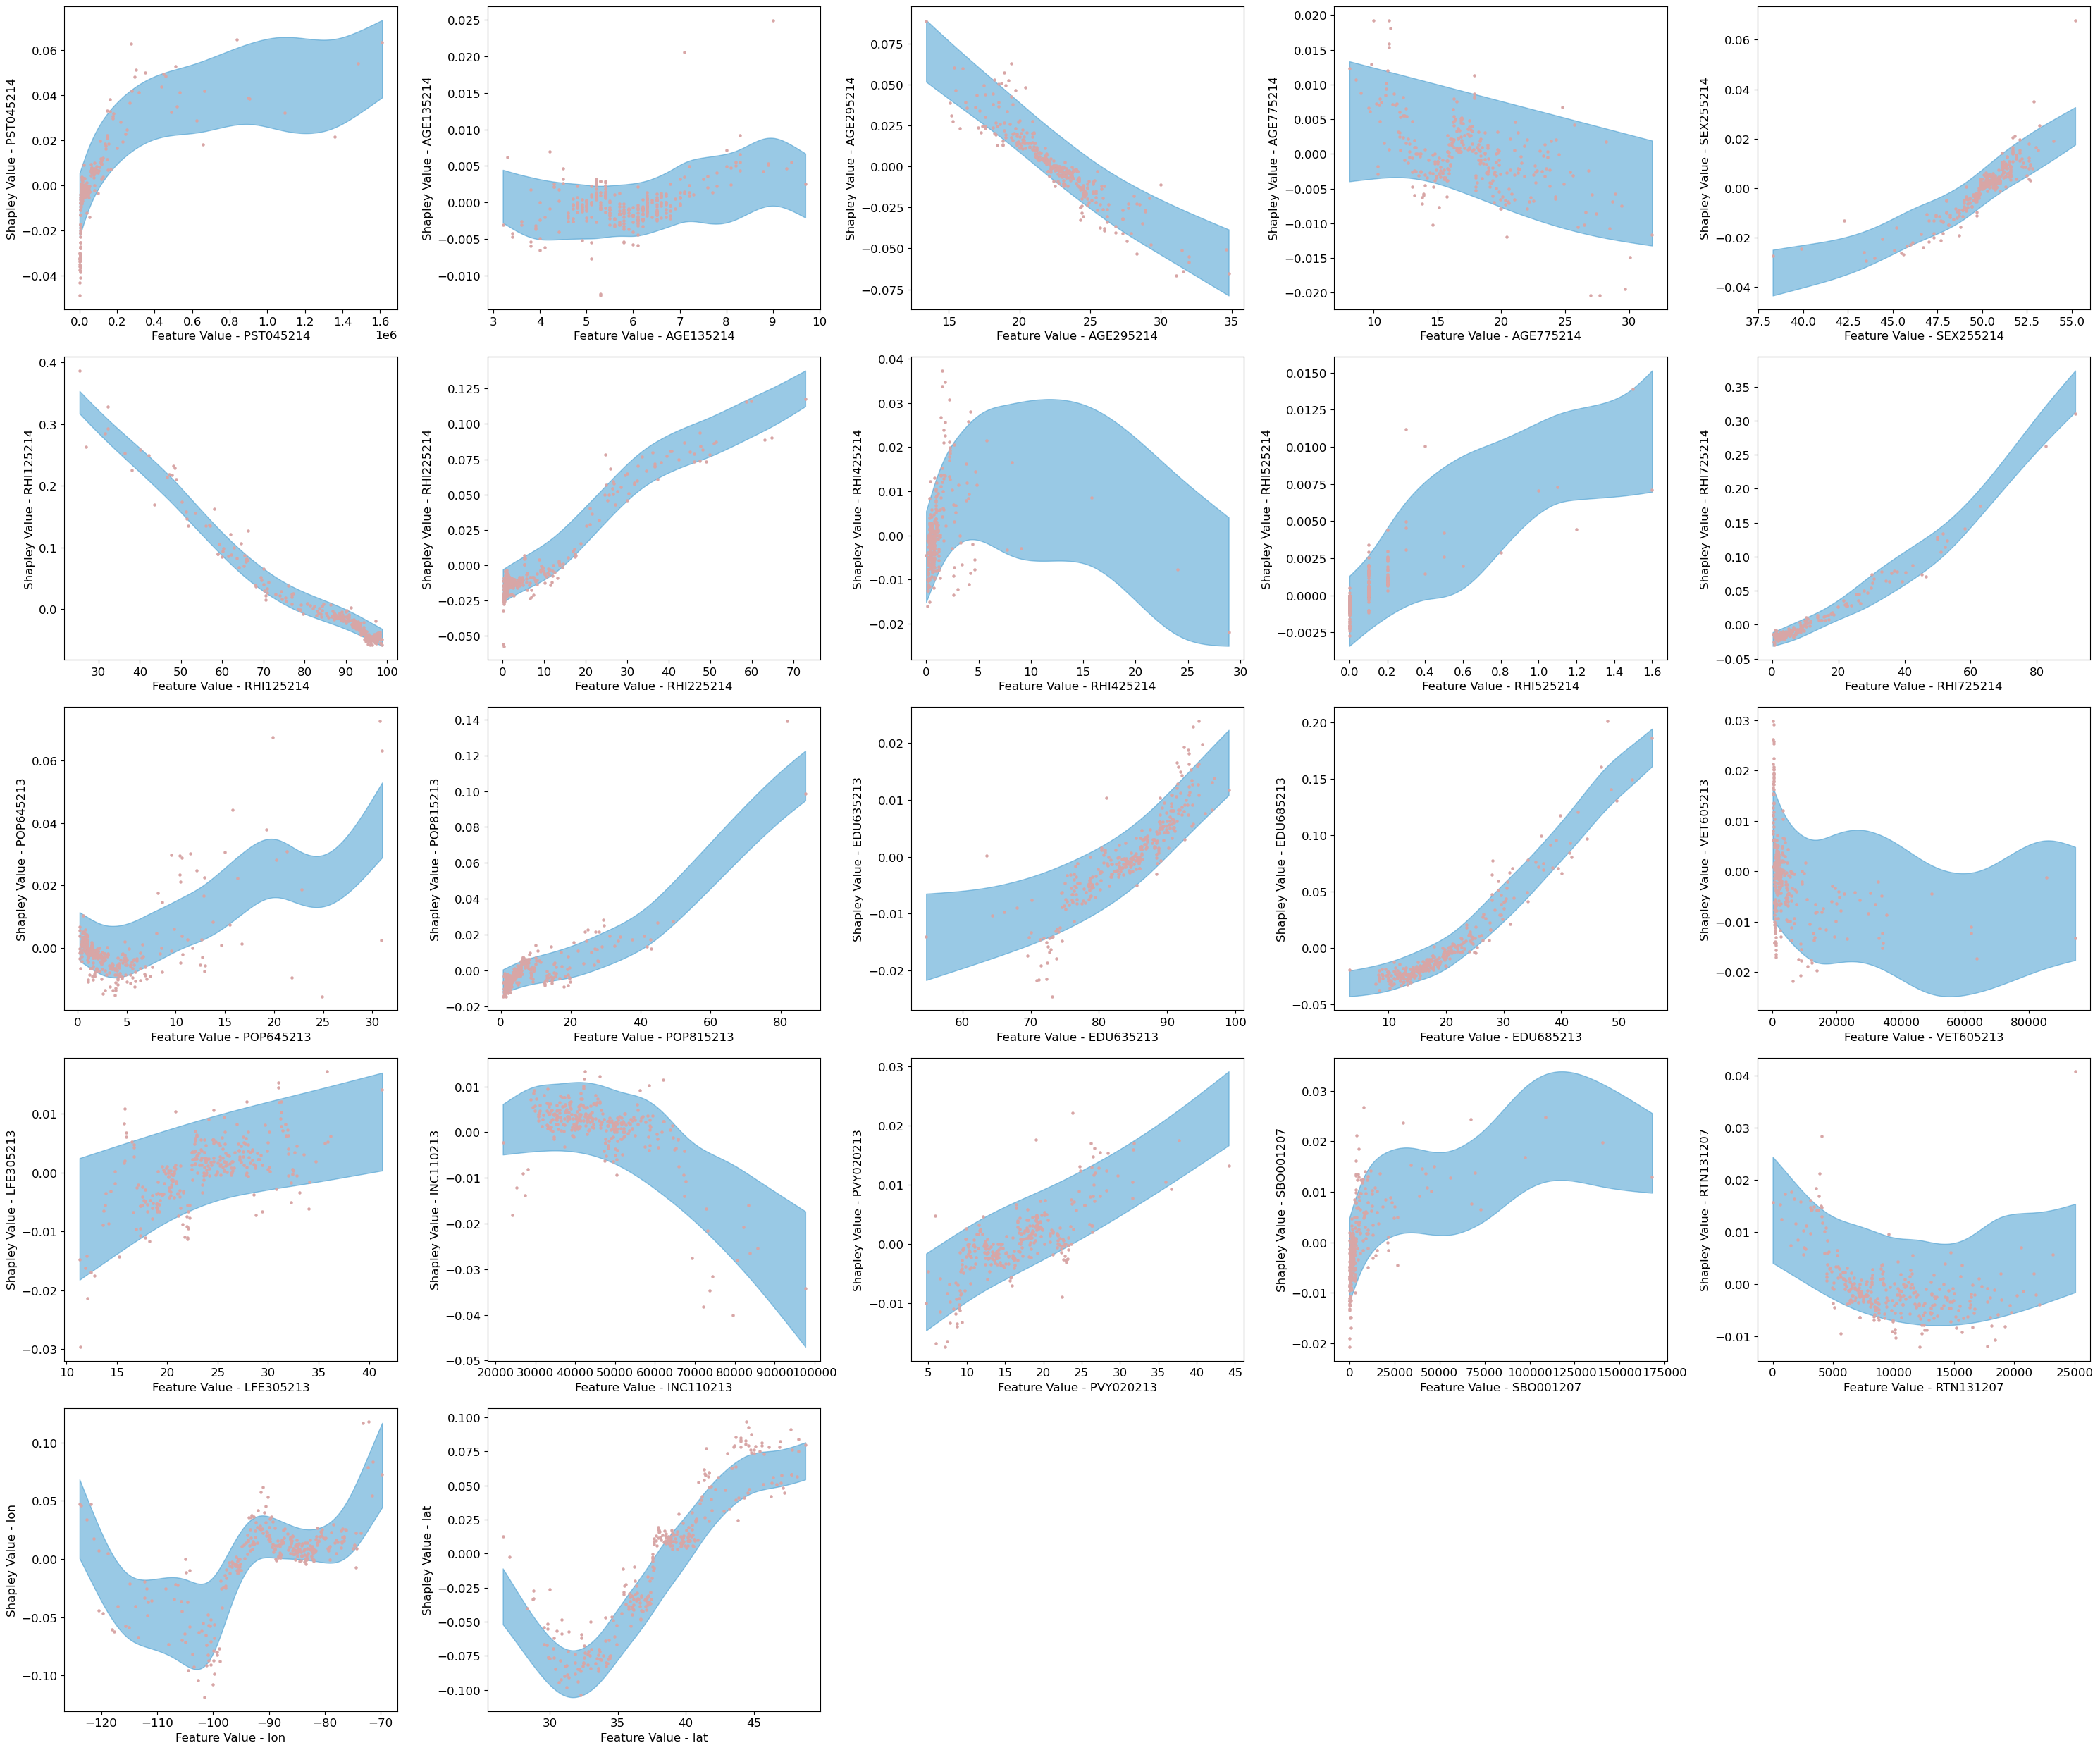

In [20]:
results.plot_partial_dependence_with_fitted_bounds(filename='USElection_partial_dependence_with_fitted_bounds.pdf')

In [21]:
import matplotlib.pyplot as plt
import geoplot as gplt
import geoplot.crs as gcrs
import contextily as cx

In [22]:
data_geo = gpd.GeoDataFrame(data, crs="EPSG:4326", geometry=gpd.points_from_xy(x=data.lon, y=data.lat))

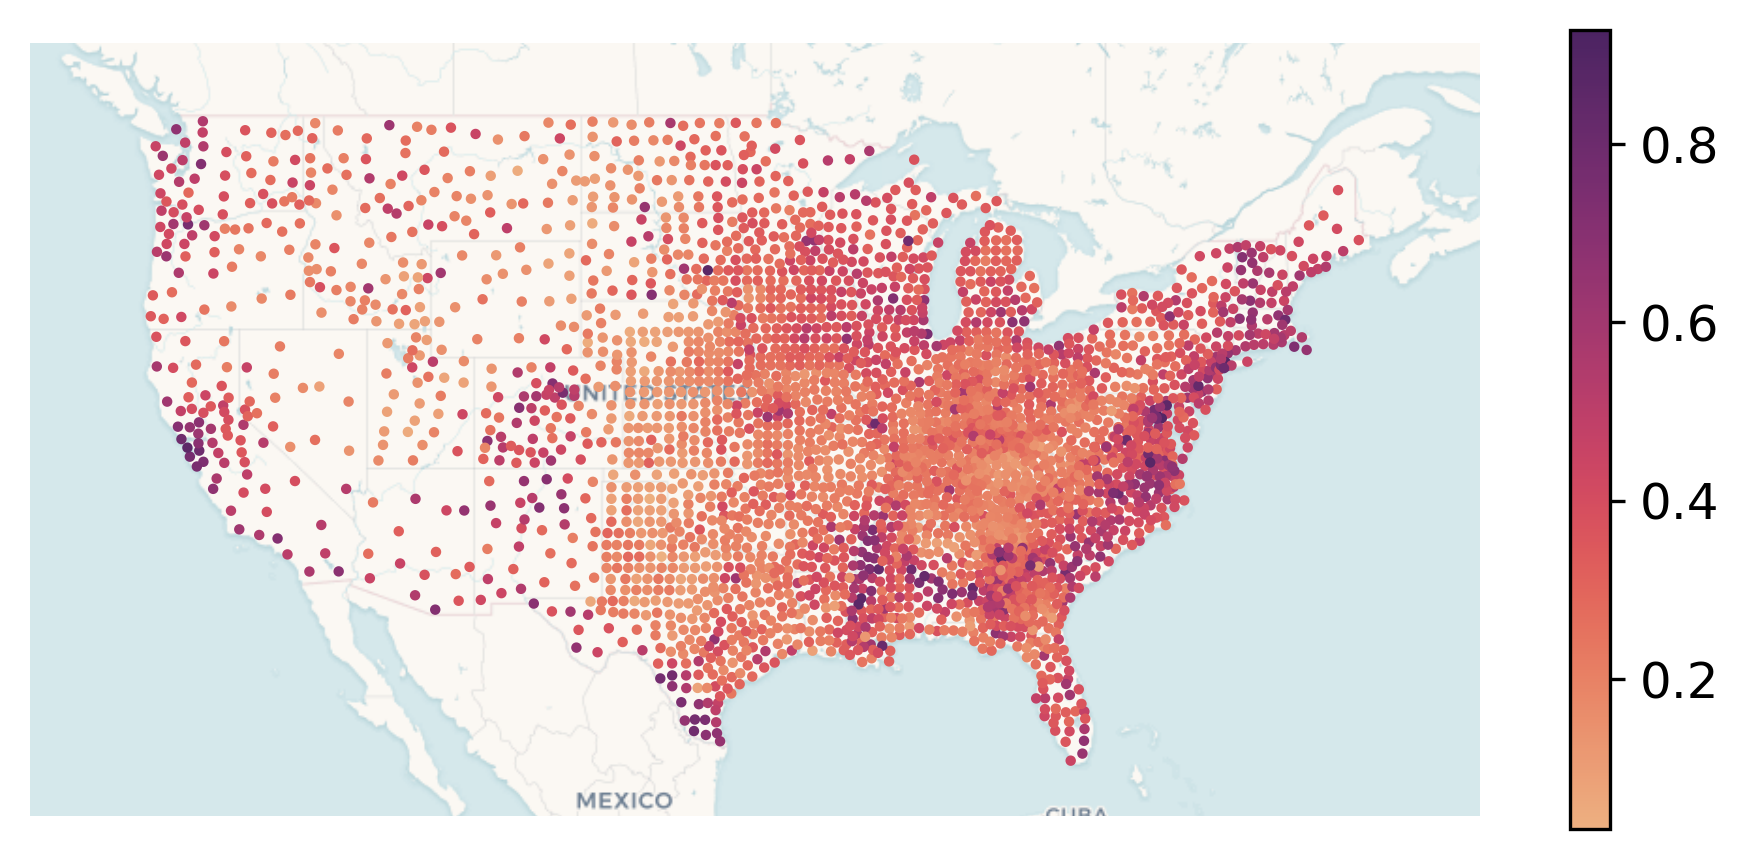

In [23]:
utm = gcrs.WebMercator()

fig, ax = plt.subplots(dpi=300, subplot_kw={'projection': utm})

gplt.webmap(data_geo, projection=utm, provider=cx.providers.CartoDB.Voyager, ax=ax)
gplt.pointplot(data_geo, hue='pct_dem_16', cmap='flare', legend=True, legend_kwargs={'shrink': 0.6}, s=1.5, ax=ax)

plt.tight_layout()
plt.savefig('./us_election_dem_percent_distribution.pdf')
plt.show()

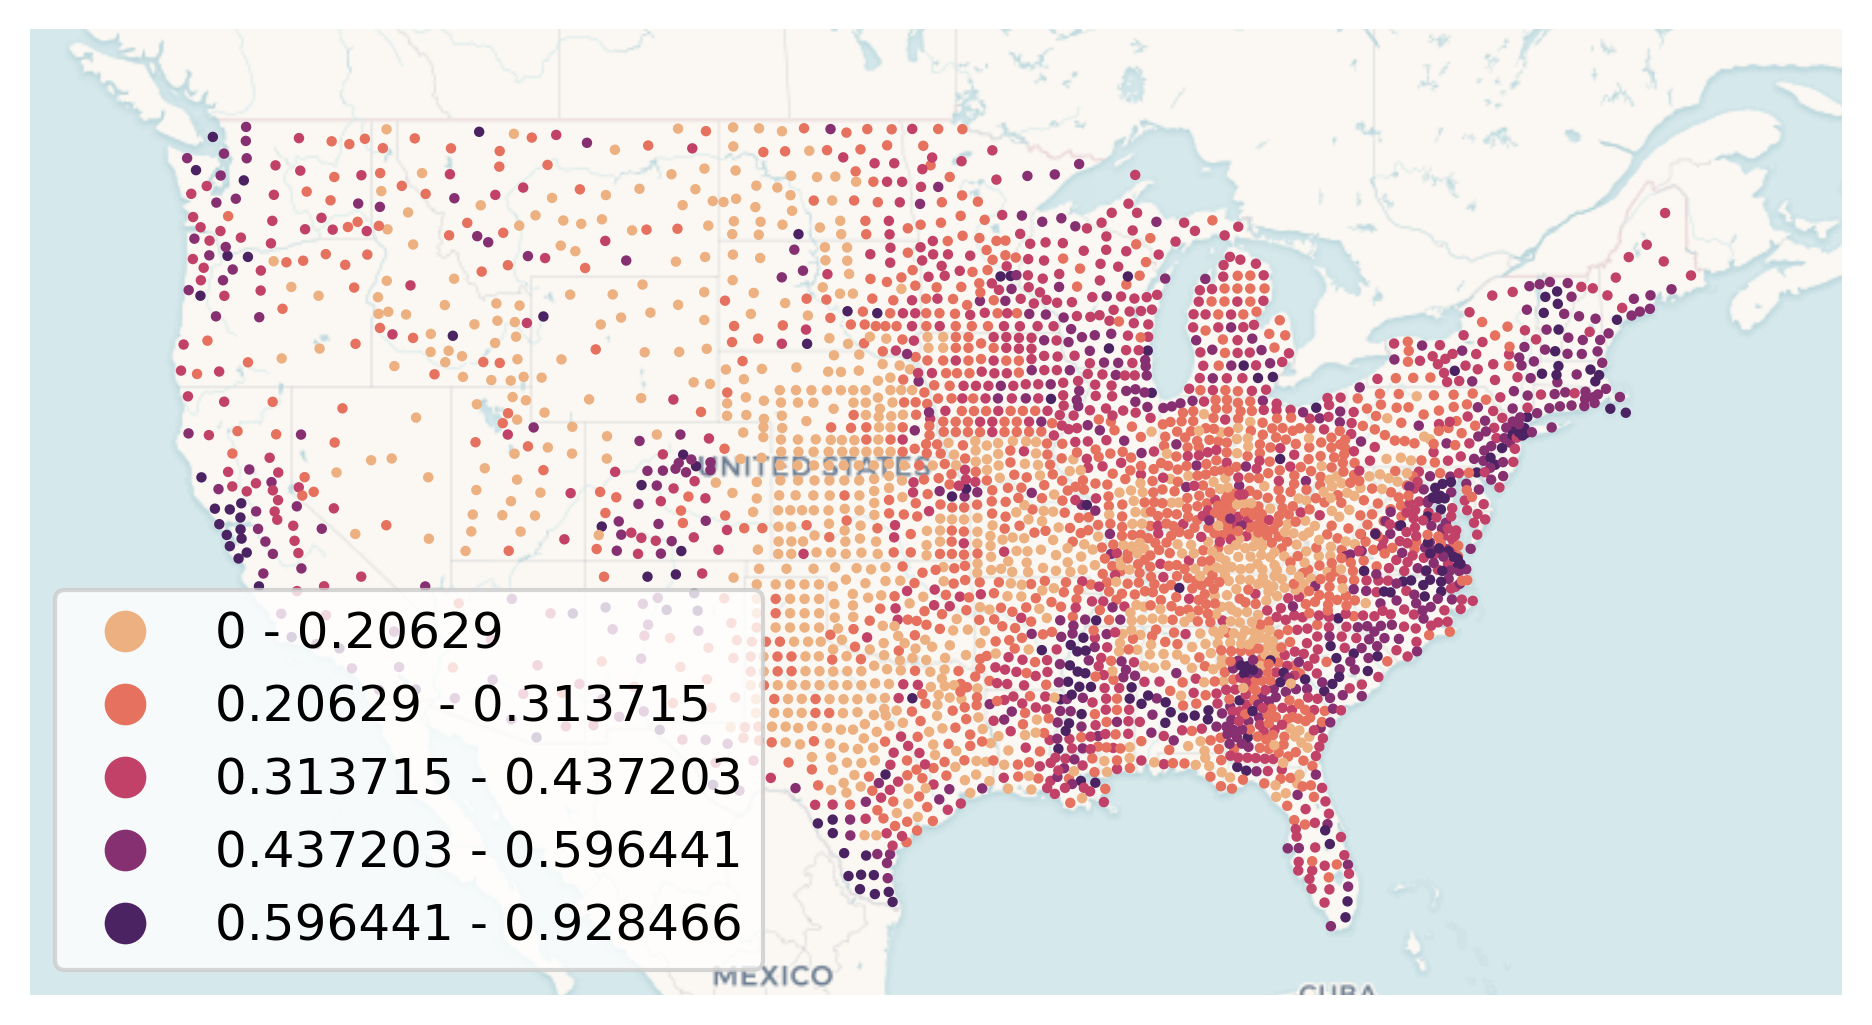

In [24]:
utm = gcrs.WebMercator()

fig, ax = plt.subplots(dpi=300, subplot_kw={'projection': utm})

gplt.webmap(data_geo, projection=utm, provider=cx.providers.CartoDB.Voyager, ax=ax)
gplt.pointplot(data_geo, hue='pct_dem_16', cmap='flare', legend=True, s=1.5, ax=ax, scheme='NaturalBreaks')

plt.tight_layout()
plt.savefig('./us_election_distribution_natural_breaks.pdf')
plt.show()